# Pronostico de potencia

In [1]:
import datetime
import inspect
import os

# scientific python add-ons
import numpy as np
import pandas as pd

# plotting stuff
# first line makes the plots appear in the notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib as mpl

# finally, we import the pvlib library
from pvlib import solarposition, irradiance, atmosphere, pvsystem, inverter, temperature
from pvlib.forecast import GFS, NAM, NDFD, RAP, HRRR

/Users/luisvargas/Desktop/Tesis Pvlib/env_pvlib_tesis/lib/python3.8/site-packages/pvlib/forecast.py:18: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  warnings.warn(


### Load Forecast data

pvlib forecast module only includes several models. To see the full list of forecast models visit the Unidata website:

http://www.unidata.ucar.edu/data/#tds


In [2]:
# Choose a location.
# Tucson, AZ
latitude = 20.56
longitude = -103.22 
tz = 'America/Mexico_City'

Definir algunos parametros del sistema fotovoltaico.

In [3]:
surface_tilt = 30
surface_azimuth = 180 # pvlib uses 0=North, 90=East, 180=South, 270=West convention
albedo = 0.2

In [4]:
start = pd.Timestamp(datetime.date.today(), tz=tz) # today's date
end = start + pd.Timedelta(days=7) # 7 days from today

In [5]:
# Define forecast model
fm = GFS()
#fm = NAM()
#fm = NDFD()
#fm = RAP()
#fm = HRRR()

In [6]:
# Retrieve data
forecast_data = fm.get_processed_data(latitude, longitude, start, end)

In [7]:
forecast_data.head()

,temp_air,wind_speed,ghi,dni,dhi,total_clouds,low_clouds,mid_clouds,high_clouds
2020-11-25 06:00:00-06:00,13.850006,1.449213,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2020-11-25 09:00:00-06:00,12.669678,0.768300,327.710856,643.529319,85.620215,0.0,0.0,0.0,0.0
2020-11-25 12:00:00-06:00,11.881683,0.247839,753.701265,818.000561,151.915081,0.0,0.0,0.0,0.0
2020-11-25 15:00:00-06:00,22.150330,0.694900,580.444603,793.916137,111.356763,0.0,0.0,0.0,0.0
2020-11-25 18:00:00-06:00,37.649994,0.199414,2.686349,0.000000,2.686349,12.0,0.0,0.0,12.0


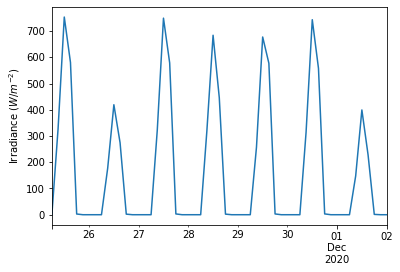

In [8]:
ghi = forecast_data['ghi']
ghi.plot()
plt.ylabel('Irradiance ($W/m^{-2}$)');


### Calculate modeling intermediates

Before we can calculate power for all the forecast times, we will need to calculate:

    solar position
    extra terrestrial radiation
    airmass
    angle of incidence
    POA sky and ground diffuse radiation
    cell and module temperatures

The approach here follows that of the pvlib tmy_to_power notebook. You will find more details regarding this approach and the values being calculated in that notebook.
Solar position

Calculate the solar position for all times in the forecast data.

The default solar position algorithm is based on Reda and Andreas (2004). Our implementation is pretty fast, but you can make it even faster if you install numba and use add method='nrel_numba' to the function call below.


In [9]:
# retrieve time and location parameters
time = forecast_data.index
a_point = fm.location

<AxesSubplot:>

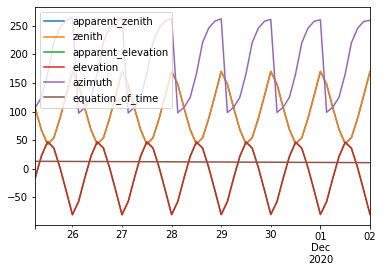

In [10]:
solpos = a_point.get_solarposition(time)
solpos.plot()

Text(0, 0.5, 'Extra terrestrial radiation ($W/m^{-2}$)')

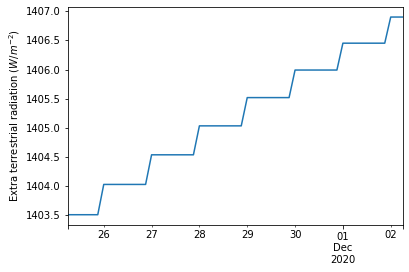

In [11]:
dni_extra = irradiance.get_extra_radiation(fm.time)
dni_extra.plot()
plt.ylabel('Extra terrestrial radiation ($W/m^{-2}$)')

Text(0, 0.5, 'Airmass')

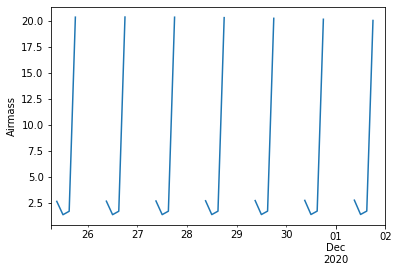

In [12]:
airmass = atmosphere.get_relative_airmass(solpos['apparent_zenith'])
airmass.plot()
plt.ylabel('Airmass')

Text(0, 0.5, 'Irradiance ($W/m^{-2}$)')

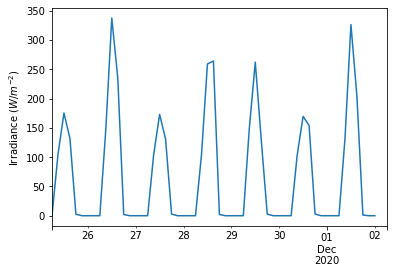

In [13]:
poa_sky_diffuse = irradiance.haydavies(surface_tilt, surface_azimuth,
                                       forecast_data['dhi'], forecast_data['dni'], dni_extra,
                                       solpos['apparent_zenith'], solpos['azimuth'])
poa_sky_diffuse.plot()
plt.ylabel('Irradiance ($W/m^{-2}$)')

Text(0, 0.5, 'Irradiance ($W/m^{-2}$)')

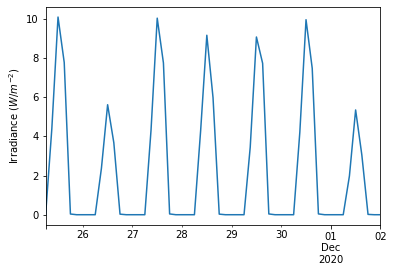

In [14]:
poa_ground_diffuse = irradiance.get_ground_diffuse(surface_tilt, ghi, albedo=albedo)
poa_ground_diffuse.plot()
plt.ylabel('Irradiance ($W/m^{-2}$)')

Text(0, 0.5, 'Angle of incidence (deg)')

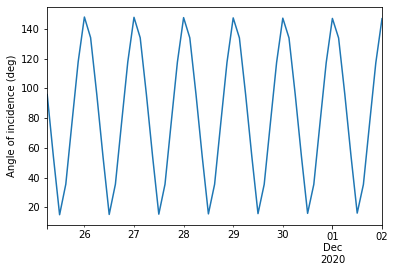

In [15]:
aoi = irradiance.aoi(surface_tilt, surface_azimuth, solpos['apparent_zenith'], solpos['azimuth'])
aoi.plot()
plt.ylabel('Angle of incidence (deg)')

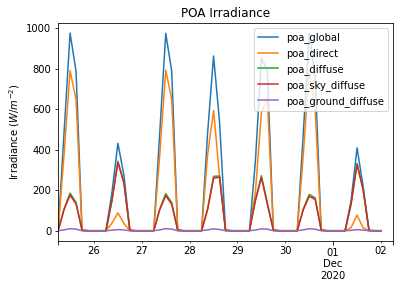

In [16]:
poa_irrad = irradiance.poa_components(aoi, forecast_data['dni'], poa_sky_diffuse, poa_ground_diffuse)
poa_irrad.plot()
plt.ylabel('Irradiance ($W/m^{-2}$)')
plt.title('POA Irradiance');

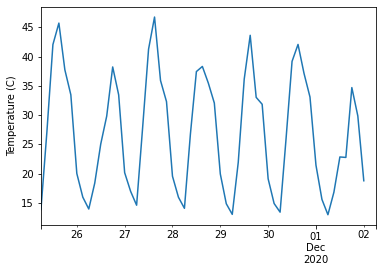

In [17]:
ambient_temperature = forecast_data['temp_air']
wnd_spd = forecast_data['wind_speed']
thermal_params = temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
pvtemp = temperature.sapm_cell(poa_irrad['poa_global'], ambient_temperature, wnd_spd, **thermal_params)
pvtemp.plot()
plt.ylabel('Temperature (C)');

In [61]:
cec_modules = pvsystem.retrieve_sam('cecmod')

In [67]:
cec_module = cec_modules.Canadian_Solar_Inc__CS6X_320P
cec_module

Technology           Multi-c-Si
Bifacial                      0
STC                     319.792
PTC                       292.8
A_c                       1.901
Length                    1.948
Width                     0.976
N_s                          72
I_sc_ref                   9.26
V_oc_ref                   45.3
I_mp_ref                   8.69
V_mp_ref                   36.8
alpha_sc               0.004389
beta_oc               -0.139116
T_NOCT                     45.8
a_ref                   1.78528
I_L_ref                  9.2705
I_o_ref             8.72084e-11
R_s                    0.362235
R_sh_ref                319.379
Adjust                  5.85738
gamma_r                 -0.4002
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: Canadian_Solar_Inc__CS6X_320P, dtype: object

In [68]:
sandia_modules = pvsystem.retrieve_sam('SandiaMod')

In [69]:
sandia_module = sandia_modules.Canadian_Solar_CS5P_220M___2009_
sandia_module

Vintage                                                          2009
Area                                                            1.701
Material                                                         c-Si
Cells_in_Series                                                    96
Parallel_Strings                                                    1
Isco                                                          5.09115
Voco                                                          59.2608
Impo                                                          4.54629
Vmpo                                                          48.3156
Aisc                                                         0.000397
Aimp                                                         0.000181
C0                                                            1.01284
C1                                                         -0.0128398
Bvoco                                                        -0.21696
Mbvoc               

### Nota rapida
No hay manera de usar .sapm_effective_irradiance() con un cec_module, investigar como hacer una simulación con cec_modules

In [65]:
effective_irradiance = pvsystem.sapm_effective_irradiance(poa_irrad.poa_direct, poa_irrad.poa_diffuse, 
                                                          airmass, aoi, cec_module)

KeyError: 'A4'

In [ ]:
sapm_out = pvsystem.sapm(effective_irradiance, pvtemp, cec_module)
#print(sapm_out.head())
sapm_out[['p_mp']].plot()
plt.ylabel('DC Power (W)');

In [26]:
sapm_inverters = pvsystem.retrieve_sam('sandiainverter')

In [27]:
sapm_inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
sapm_inverter

Vac                          208
Pso                      2.08961
Paco                         250
Pdco                     259.589
Vdco                          40
C0                      -4.1e-05
C1                      -9.1e-05
C2                      0.000494
C3                     -0.013171
Pnt                        0.075
Vdcmax                        50
Idcmax                   6.48972
Mppt_low                      30
Mppt_high                     50
CEC_Date                     NaN
CEC_Type     Utility Interactive
Name: ABB__MICRO_0_25_I_OUTD_US_208__208V_, dtype: object

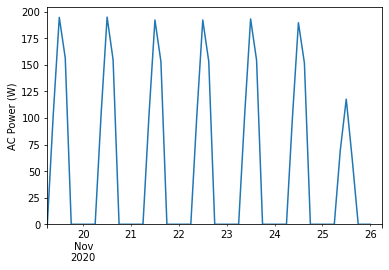

In [28]:
p_ac = inverter.sandia(sapm_out.v_mp, sapm_out.p_mp, sapm_inverter)

p_ac.plot()
plt.ylabel('AC Power (W)')
plt.ylim(0, None);

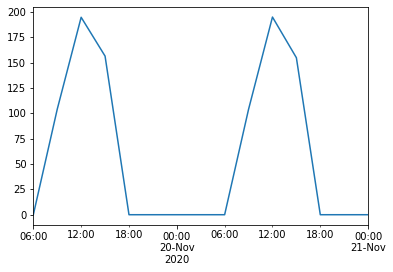

In [29]:
p_ac[start:start+pd.Timedelta(days=2)].plot();

In [30]:
p_ac.describe()

count     55.000000
mean      53.501645
std       73.756338
min       -0.075000
25%       -0.075000
50%       -0.075000
75%      104.000832
max      195.037306
dtype: float64

In [31]:
p_ac.index.freq

In [32]:
# integrate power to find energy yield over the forecast period
p_ac.sum() * 3

8827.771424062865